<a href="https://colab.research.google.com/github/desultir/assign1/blob/master/assign2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
  
#!cd "/content/drive/My Drive/Colab Notebooks/PretrainedModels" && tar xvzf *.tar.gz
#!cd "/content/drive/My Drive/Colab Notebooks/Input" && tar xvzf test.tar.gz

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
#install tensorboard tunnel
#https://www.dlology.com/blog/quick-guide-to-run-tensorboard-in-google-colab/
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

--2019-05-13 03:11:00--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.195.49.195, 35.172.177.65, 54.236.200.27, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.195.49.195|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16529980 (16M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  15.76M  15.7MB/s    in 1.0s    

2019-05-13 03:11:01 (15.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [16529980/16529980]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
MODEL_DIR = "/content/drive/My Drive/Colab Notebooks/PretrainedModels/"
MODEL_NAME = "faster_rcnn_resnet50_coco_2018_01_28"

LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

In [4]:
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://52dce7e6.ngrok.io


In [0]:
from matplotlib.image import imread
import PIL.Image
from PIL import ImageOps
import numpy as np
import io

def normalize_image(rgb):
  white_rgb = rgb - np.mean(rgb)
  white_rgb = white_rgb / np.max(np.abs(white_rgb))
  return white_rgb

def decompress_expand(jpg):
  #zero pad to 320x320
  encoded_jpg_io = io.BytesIO(jpg)
  image = PIL.Image.open(encoded_jpg_io)
  DESIRED_SIZE = 320
  widthpad = (DESIRED_SIZE - image.width)
  heightpad = (DESIRED_SIZE - image.height)
  padding = (widthpad//2, heightpad//2, widthpad - widthpad//2, heightpad-heightpad//2)
  padded = ImageOps.expand(image, padding)
  return padded


def load_and_preprocess(path):
  with tf.gfile.GFile(path, 'rb') as fp:
    jpg = fp.read()
  return decompress_expand(jpg)

def load_np(paths):
  return np.stack([imread(x) for x in paths])

(2, 320, 320, 3)

In [0]:
import glob
import csv
import tensorflow as tf
import os
from tensorflow.core.framework import graph_pb2
from tensorflow.python.saved_model import loader
AUTOTUNE = tf.data.experimental.AUTOTUNE

#load train images
train_img_list = glob.glob(r"/content/drive/My Drive/Colab Notebooks/Input/train2014/*.jpg")
image_list = list(map(load_and_preprocess, train_img_list[:30]))
#train_img_list_ds = tf.data.Dataset.from_tensor_slices(image_list)
#load train labels
train_labels_filename = r"/content/drive/My Drive/Colab Notebooks/Input/train.txt"
with open(train_labels_filename) as f:
  reader = csv.reader(f, delimiter='\t')
  train_labels = {k:v for k, v in reader}

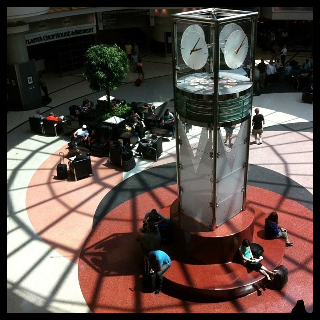

In [79]:
image_list[3]

In [48]:
#load the trainable model from the checkpoint
sess = tf.Session()

saver = tf.train.import_meta_graph(os.path.join(MODEL_DIR,MODEL_NAME, 'model.ckpt.meta'))
saver.restore(sess, os.path.join(MODEL_DIR,MODEL_NAME, 'model.ckpt'))



INFO:tensorflow:Restoring parameters from /content/drive/My Drive/Colab Notebooks/PretrainedModels/faster_rcnn_resnet50_coco_2018_01_28/model.ckpt


In [0]:
# write graph for tensorboard
summary_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)

In [0]:
stacked_imgs = np.stack(image_list)
result = sess.run(("detection_classes:0", "detection_scores:0"), feed_dict={"image_tensor:0": stacked_imgs})

In [75]:
result[0][3] # prediction

array([ 1., 85., 64., 85., 33.,  1., 19., 28., 31.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

In [76]:
result[1][3] # confidence

array([0.9916928 , 0.9882533 , 0.9400895 , 0.88384396, 0.6351711 ,
       0.49882242, 0.39083028, 0.34901962, 0.32091033, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [82]:
sess.model.summary()

AttributeError: ignored